**本課題のディープラーニングによる分析の目的：**

あるプロサッカー選手が将来(5年後)世界のトッププレーヤーに育つか予測するモデルを作成します。

このモデルによって、例えば日本代表の選手が、将来世界のトッププレイヤーに育つのかを予測できます。

今回の分析の最後に、例として、日本代表の久保建英選手が、5年後世界のトッププレイヤーに育っているかを検証します。

**方法：**

サッカーゲームFIFAシリーズの選手データセットを活用します。

サッカーゲームFIFAシリーズは、全世界で最も人気のあるテレビゲーム用サッカーゲームです。

FIFA22では、世界中の55つの主要なプロサッカーリーグの、19239名の実在のプロサッカー選手が登録されています。
 
FIFAシリーズでは、毎年チームに在籍する世界中のサッカー選手の能力値が設定されています。

そして、その能力値のデータベースもkaggleで入手が可能です。

kaggleでは、2015年から2022年まで、毎年の選手の在籍データが入手可能でした。

各選手能力値は、ゲーム制作会社EAスポーツの主観的リサーチに基づく判断によって決められているものの、素人が設定するよりもはるかに精密に選手の特性をつかみ、適正な能力値を設定しています。よって、この能力値を実在の選手の能力の近似値とすることができます。

**特徴量**

2017年時点の選手の能力値および年齢、およびサッカー強豪国とされる国の国籍のカテゴリー変数

**目的変数**

「2022年時点で、FIFA22が設定した総合能力値80を超えたか否か」

ディープラーニングで確率を算出し、確率50%を超える選手を、将来能力値80を超える選手であると予測し、テストデータを使いその正答率を見ていきます。

実際に行った分析のプロセスは以下の通りです。

------------------------------------------------------------------------------------
1. データの理解と把握
df.head()
df.shape
総合能力値のヒストグラム
欠損値の確認
groupbyで国籍別の平均総合能力値、登録の把握
.describe()で平均年齢の把握

2. 前処理
標準化
国籍をカテゴリー変数に変更
　一部の国籍にカテゴリー変数を絞る
目的変数が1と0のうち、1をとる値が著しく少ないので、目的変数が1と0のサンプル数が同数になるようにデータの数を調節

3. 訓練用データとテスト用データに分ける
　ホールドアウト法（テストサイズ0.3）

4. ディープラーニング
　ノード数を決める
　隠れ層数を決める
　オプティマイザを決める
　エポック数を決める

5. モデルの精度を上げる
　重みの正則化(L2)
  ノード数変更

6. 正答率で精度の検証



In [1]:
#ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

%matplotlib inline
pd.options.display.max_columns = None

In [2]:
#FIFA2022の選手データをインポート
df = pd.read_csv(r"players_22.csv")

C:\Users\x250\AppData\Local\Temp\ipykernel_14564\2752769538.py:2: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"players_22.csv")


In [3]:
#5件分を表示
df.head()

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,93,78000000.0,320000.0,34,1987-06-24,170,72,73.0,Paris Saint-Germain,French Ligue 1,1.0,RW,30.0,NaN,2021-08-10,2023.0,52,Argentina,1369.0,RW,10.0,Left,4,4,5,Medium/Low,Unique,Yes,144300000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...","Finesse Shot, Long Shot Taker (AI), Playmaker ...",85.0,92.0,91.0,95.0,34.0,65.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,20,35,24,6,11,15,14,8,NaN,89+3,89+3,89+3,92,93,93,93,92,93,93,93,91+2,87+3,87+3,87+3,91+2,66+3,64+3,64+3,64+3,66+3,61+3,50+3,50+3,50+3,61+3,19+3,https://cdn.sofifa.net/players/158/023/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,https://cdn.sofifa.net/teams/1369/60.png,https://cdn.sofifa.net/flags/ar.png
1,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,ST,92,92,119500000.0,270000.0,32,1988-08-21,185,81,21.0,FC Bayern München,German 1. Bundesliga,1.0,ST,9.0,NaN,2014-07-01,2023.0,37,Poland,1353.0,RS,9.0,Right,4,4,5,High/Medium,Unique,Yes,197200000.0,"#Aerial Threat, #Distance Shooter, #Clinical F...","Solid Player, Finesse Shot, Outside Foot Shot,...",78.0,92.0,79.0,86.0,44.0,82.0,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,85,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10,NaN,90+2,90+2,90+2,85,88,88,88,85,86+3,86+3,86+3,84+3,80+3,80+3,80+3,84+3,64+3,66+3,66+3,66+3,64+3,61+3,60+3,60+3,60+3,61+3,19+3,https://cdn.sofifa.net/players/188/545/22_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/1353/60.png,https://cdn.sofifa.net/flags/pl.png
2,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",91,91,45000000.0,270000.0,36,1985-02-05,187,83,11.0,Manchester United,English Premier League,1.0,ST,7.0,NaN,2021-08-27,2023.0,38,Portugal,1354.0,ST,7.0,Right,4,5,5,High/Low,Unique,Yes,83300000.0,"#Aerial Threat, #Dribbler, #Distance Shooter, ...","Power Free-Kick, Flair, Long Shot Taker (AI), ...",87.0,94.0,80.0,88.0,34.0,75.0,87,95,90,80,86,88,81,84,77,88,85,88,86,94,74,94,95,77,77,93,63,29,95,76,88,95,24,32,24,7,11,15,14,11,NaN,90+1,90+1,90+1,88,89,89,89,88,86+3,86+3,86+3,86+3,78+3,78+3,78+3,86+3,63+3,59+3,59+3,59+3,63+3,60+3,53+3,53+3,53+3,60+3,20+3,https://cdn.sofifa.net/players/020/801/22_120.png,https://cdn.sofifa.net/teams/11/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1354/60.png,https://cdn.sofifa.net/flags/pt.png


In [4]:
#全体では、19239名、110項目のデータセット
df.shape

(19239, 110)

In [5]:
#欠損データの確認
df.isnull().sum()

sofifa_id               0
player_url              0
short_name              0
long_name               0
player_positions        0
                    ...  
player_face_url         0
club_logo_url          61
club_flag_url          61
nation_logo_url     18480
nation_flag_url         0
Length: 110, dtype: int64

In [6]:
#FIFA22における登録リーグ数
len(df[["league_name"]].groupby("league_name").count())

55

In [7]:
#FIFA2017の選手データをインポート
df2017 = pd.read_csv(r"players_17.csv")

In [8]:
#同110項目、17596名分のデータセット
df2017.shape

(17596, 110)

In [9]:
#2017年の登録選手数は17596名
len(df2017)

17596

In [10]:
#FIFA2017に登録の選手のうち、FIFA2022でもプレイヤーとして登録されている選手を抽出し、FIFA2022でのその選手たちの総合能力値(列名:overall)をFIFA2017のデータセットに結合します。

#方法: FIFA2017の選手ID(列名:sofifa id)をfor文で回して、その選手IDのうち、FIFA2022でも登録されている選手のoverallの項目のリストを作ります。

overall2022 = []
for i in df2017["sofifa_id"]:
    playeroverall = df[df["sofifa_id"] == i].loc[:,"overall"].values
    if len(playeroverall) > 0:
        overall2022.append(playeroverall.astype(int))        
        
#FIFA2017のデータセットで登録されていたFIFA2022に登録されていない選手は、元のdf2017のデータから削除する。
    else:
        target = df2017.index[(df2017["sofifa_id"] == i)]
        df2017 = df2017.drop(target)


In [11]:
#FIFA2017に登録されている17596名の選手のうちFIFA2022に残っているのは7420名
len(df2017)

7420

<AxesSubplot:>

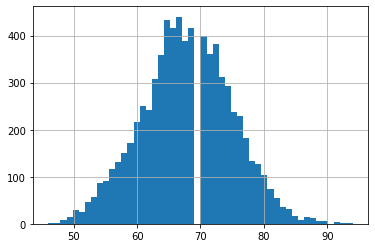

In [12]:
#7420名の選手の総合能力値のヒストグラム
df2017["overall"].hist(bins = 50)

<AxesSubplot:xlabel='nationality_name'>

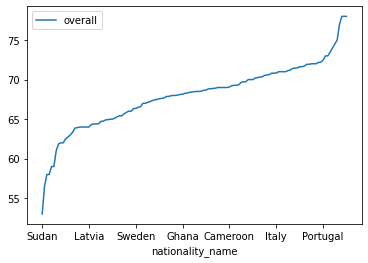

In [13]:
#データの理解
#国籍によって平均総合能力値にばらつきがある
overall_by_nationality = df2017[["overall","nationality_name"]].groupby("nationality_name").mean().sort_values("overall").reset_index()

# 線グラフを表示
overall_by_nationality.plot(x="nationality_name")

In [14]:
df2017[["overall","nationality_name"]].groupby("nationality_name").mean().sort_values("overall").tail(20)

,overall
nationality_name,
Spain,71.627049
Slovenia,71.705882
Uruguay,71.935484
Serbia,71.938776
Togo,72.000000
Tanzania,72.000000
Zambia,72.000000
Ukraine,72.176471
Gabon,72.200000


**上記データの理解**

平均総合能力値が高い国にヨーロッパの国が並ぶ中で、アジアやアフリカの強豪ではない国も平均能力値が高くなっています。
これは、登録選手数が少ない国籍の選手が、たまたま総合能力値が高かっただけであると推測できます。

**考察**

登録選手数が少ない国籍は、一人一人の選手の総合能力値に左右されやすい為、国籍をカテゴリー変数として説明変数に入れる場合、いくつかの国に絞ることにします。


In [15]:
df2017["nationality_name"].value_counts().head(20)

England                833
Brazil                 507
Spain                  488
France                 459
Argentina              433
Germany                425
Italy                  204
Japan                  199
Netherlands            191
Sweden                 170
Norway                 166
Colombia               164
Portugal               161
Republic of Ireland    152
Denmark                145
Mexico                 145
United States          136
Scotland               135
Belgium                134
Poland                 134
Name: nationality_name, dtype: int64

**上記データの理解**

選手の国籍はヨーロッパが多い。Jリーグが登録されている関係で日本人選手も多い。


In [16]:
print(df2017["age"].describe())
print(df2017["age"].median())

count    7420.000000
mean       23.834232
std         3.769868
min        16.000000
25%        21.000000
50%        24.000000
75%        26.000000
max        38.000000
Name: age, dtype: float64
24.0


**上記データの理解**

年齢の平均はおよそ24歳。中央値も24歳。


In [17]:
print("{:.2%}".format(len(df2017[df2017["overall"] >= 80])/len(df2017["overall"])))

4.97%


**上記データの理解**

FIFA2017に登録されていた選手で、FIFA2022もプレイヤーとして登録されている選手のうち、総合能力値が80を超えている選手は約5%しかいません。

**考察**

よって、総合能力値80を超えたかどうかが、世界のトッププレイヤーであると、定義します。


**ここからはデータの前処理**

In [18]:
#overall2022は中身がnd配列になっているので、リストにする。
overall2022_temp = []
for j in range(len(overall2022)):
    overall2022_temp.append(overall2022[j].tolist())
overall2022_list = []
for k in range(len(overall2022_temp)):
    overall2022_list.append(overall2022_temp[k][0])

In [19]:
#df2017にoverall2022の列を追加
df2017["overall2022"] = overall2022_list

**データの前処理**

FIFA2017年の選手の総合能力値ではなく、FIFA2017時点のその選手の総合能力値と、総合能力値80までの差を表す説明変数を作ります。


In [20]:
#FIFA2017年の選手の総合能力値ではなく、FIFA2017時点のその選手の総合能力値と、総合能力値80までの差を表す説明変数を作る。
df2017["distance_to_80"] = 80 - df2017["overall"]

<AxesSubplot:>

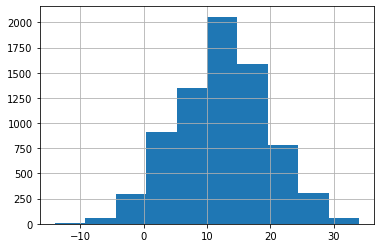

In [21]:
df2017["distance_to_80"].hist()

**データの前処理**

FIFA2022で総合能力値80を超えた選手を1とする列を作ります。

In [22]:
#FIFA2022で総合能力値80を超えた選手を1とする列を作る。
over80 = (df2017["overall2022"] >= 80).astype(np.int32)
df2017["over80_2022"] = over80

df2017から重要な変数(選手ID、選手名、現在総合能力値と総合能力値80までの差、FIFA2022で総合能力値80を超えたか、FIFA2022での総合能力値、国籍、年齢)だけに絞ったリストを作ります。

In [23]:
#df2017から重要な変数(選手ID、選手名、現在総合能力値と総合能力値80までの差、FIFA2022で総合能力値80を超えたか、FIFA2022での総合能力値、国籍、年齢)だけに絞ったリストを作る
df2017_revised = pd.DataFrame(data = df2017.loc[:,["sofifa_id","short_name","overall","distance_to_80","over80_2022","overall2022","nationality_name","age"]])

In [24]:
df2017_revised.shape

(7420, 8)

In [25]:
#FIFA2017の時点で総合能力値80以上の選手は削除する。
over80_2017 = df2017_revised.index[(df2017_revised["overall"] >= 80)]
df2017_revised2 = df2017_revised.drop(over80_2017)

In [26]:
#FIFA2017時点での総合能力値は80以下で、FIFA2022で総合能力値80を超えた選手数は257名
df2017_revised2["over80_2022"].sum()

257

**データの前処理**

StandardScalerで、現在能力値と能力値80までの差、と年齢の項目の標準化を実施します。


In [27]:
#データの前処理
# StandardScalerで、カテゴリー変数以外の項目の標準化を実施
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
df2017_temp1 = df2017_revised2[["distance_to_80","age"]]
std = sc.fit_transform(df2017_temp1)

In [28]:
df2017_revised2_std = df2017_revised2.copy()

In [29]:
df2017_revised2_std["distance_to_80"] = std[:,0]
df2017_revised2_std["age"] = std[:,1]

**考察**

FIFA2017に総合能力値が80以下だった選手で、総合能力値80をFIFA2022に超えた選手は全体の3.64％しかいません。
これではデータに偏りが出て、正確な予測が難しくなります。

In [30]:
#FIFA2017に総合能力値が80以下だった選手で、総合能力値80をFIFA2022に超えた選手は全体の3.64％しかいない
print("{:.2%}".format(df2017_revised2_std["over80_2022"].sum()/len(df2017_revised2_std)))
#これではデータに偏りが出て、正確な予測が難しくなる。

3.64%


**データの前処理　（サンプル数調整）**

そこで、目的変数が1と0（FIFA2022で総合能力値が80を超えたか超えていないか）のサンプル数を同等にする対策をとります。

FIFA2017時点で総合能力値が80以下だった選手で、FIFA2022で総合能力値が80を超えた選手数は257名。この数と同等（257名）の、FIFA2022に総合能力値が80を超えなかった選手をランダムに抽出します。

合計514名のデータを作ります。

In [31]:
df2017_revised2_o80 = df2017_revised2_std[df2017_revised2_std["over80_2022"] == 1]
df2017_revised2_under80 = df2017_revised2_std[df2017_revised2_std["over80_2022"] == 0]
df2017_revised2_under80_sampled = df2017_revised2_under80.sample(257, random_state =1)
df2017_revised3 = pd.concat([df2017_revised2_under80_sampled, df2017_revised2_o80])
df2017_revised3.shape

(514, 8)

In [32]:
df_over80_2022_is_1 = df2017_revised3[df2017_revised3["over80_2022"] == 1]

In [33]:
df_over80_2022_is_1.shape

(257, 8)

In [34]:
#データの前処理
#FIFA2022年で総合能力値80を超えた選手の国籍別内訳上位10か国
df_over80_2022_is_1[["over80_2022","nationality_name"]].groupby("nationality_name").count().sort_values(by= "over80_2022", ascending=False).head(10)

,over80_2022
nationality_name,
Spain,38
Brazil,28
France,26
England,21
Argentina,17
Germany,17
Italy,14
Portugal,13
Netherlands,9


**データの前処理(カテゴリー変数化1)**

次に、国籍の変数をダミー変数にします

In [35]:
df2017_revised4 = pd.get_dummies(data=df2017_revised3, columns=["nationality_name"])
print(df2017_revised4.shape)
df2017_revised4.isnull().sum().max()
#欠損値なし

(514, 78)


0

**データの前処理（カテゴリー変数化2)**

すべての国籍のカテゴリー変数を説明変数にいれるのではなく、上記の、FIFA2022年の総合能力値が80を超えた選手が多い国籍10か国のみをカテゴリー変数に扱います。

**データの前処理（説明変数の選択)**

そのほか、FIFA2017時点の選手の年齢と、FIFA2017時点の現状総合能力値と総合能力値80までの差、を説明変数に加えます。


In [36]:
#データの前処理
#すべての国籍のカテゴリー変数を説明変数にいれるのではなく、上記の、FIFA2022年の総合能力値が80を超えた選手が多い国籍10か国のみをカテゴリー変数に扱う。
#そのほか、FIFA2017時点の選手の年齢と、FIFA2017時点の現状総合能力値と総合能力値80までの差、を説明変数に加える。
X_columns = [s for s in df2017_revised4.columns.tolist() if s in ["distance_to_80","age","nationality_name_Spain","nationality_name_Brazil","nationality_name_France","nationality_name_England","nationality_name_Argentina","nationality_name_Germany" ,"nationality_name_Italy", "nationality_name_Portugal", "nationality_name_Netherlands","nationality_name_Belgium"]]
X_columns

['distance_to_80',
 'age',
 'nationality_name_Argentina',
 'nationality_name_Belgium',
 'nationality_name_Brazil',
 'nationality_name_England',
 'nationality_name_France',
 'nationality_name_Germany',
 'nationality_name_Italy',
 'nationality_name_Netherlands',
 'nationality_name_Portugal',
 'nationality_name_Spain']

In [37]:
#再度X_columnsを作成
X_columns = [s for s in df2017_revised4.columns.tolist() if s in ["distance_to_80","age","nationality_name_Spain","nationality_name_Brazil","nationality_name_France","nationality_name_England","nationality_name_Argentina","nationality_name_Germany" ,"nationality_name_Italy", "nationality_name_Portugal", "nationality_name_Netherlands","nationality_name_Belgium"]]
X_columns

['distance_to_80',
 'age',
 'nationality_name_Argentina',
 'nationality_name_Belgium',
 'nationality_name_Brazil',
 'nationality_name_England',
 'nationality_name_France',
 'nationality_name_Germany',
 'nationality_name_Italy',
 'nationality_name_Netherlands',
 'nationality_name_Portugal',
 'nationality_name_Spain']

目的変数Yと説明変数XのNumpy配列を作成します。

In [38]:
Y = np.array(df2017_revised4["over80_2022"])
X = np.array(df2017_revised4[X_columns])

In [39]:
print("Y=", Y.shape, ", X=", X.shape)

Y= (514,) , X= (514, 12)


**データの分割**

訓練用データとテスト用データ、訓練用データのうち、再度訓練用データ、検証データに分割

In [40]:
#訓練用データ、テスト用データに分ける。上記のFIFA17やFIFA22のデータセットでは、総合能力値順にリストが並んでいるので、順番で区切ると訓練用データとテスト用データに偏りが出る。シャッフルを有効にする。
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0, shuffle = True)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.3, random_state=0, shuffle = True)

In [41]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(251, 12)
(108, 12)
(155, 12)


**学習の実施**

ディープラーニングで、学習を実施します。

In [42]:
#学習の実施
#隠れ層への出力ノードの数は、入力層の変数の数と同じで設定。
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout

# モデルの初期化
model = keras.Sequential()

# 入力層
model.add(Dense(12, activation='relu', input_shape=(12,), kernel_regularizer=regularizers.l2(0.01)))
# 出力層
model.add(Dense(1, activation='sigmoid'))

# モデルの構築
model.compile(optimizer = "adam", loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                156       
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


In [44]:
%%time
# 学習の実施
log = model.fit(X_train, Y_train, epochs=1000, batch_size=32, verbose=True,
                callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         min_delta=0, patience=20,
                                                         verbose=1)],
         validation_data=(X_valid, Y_valid))

Epoch 1/1000
8/8 [==============================] - 1s 34ms/step - loss: 0.9207 - accuracy: 0.3466 - val_loss: 0.9135 - val_accuracy: 0.3704
Epoch 2/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.8991 - accuracy: 0.3227 - val_loss: 0.8935 - val_accuracy: 0.3704
Epoch 3/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.8784 - accuracy: 0.3307 - val_loss: 0.8750 - val_accuracy: 0.3519
Epoch 4/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.8599 - accuracy: 0.3267 - val_loss: 0.8571 - val_accuracy: 0.3426
Epoch 5/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.8427 - accuracy: 0.3147 - val_loss: 0.8407 - val_accuracy: 0.3333
Epoch 6/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.8270 - accuracy: 0.3227 - val_loss: 0.8253 - val_accuracy: 0.3148
Epoch 7/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.8108 - accuracy: 0.3546 - val_loss: 0.8114 - val_accuracy: 0.3333
Epoch 8/1000
8/8 [=

8/8 [==============================] - 0s 7ms/step - loss: 0.5138 - accuracy: 0.7849 - val_loss: 0.5210 - val_accuracy: 0.8056
Epoch 60/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.5119 - accuracy: 0.7968 - val_loss: 0.5191 - val_accuracy: 0.7963
Epoch 61/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.5102 - accuracy: 0.7968 - val_loss: 0.5171 - val_accuracy: 0.7963
Epoch 62/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.5083 - accuracy: 0.8008 - val_loss: 0.5153 - val_accuracy: 0.7963
Epoch 63/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.5064 - accuracy: 0.8008 - val_loss: 0.5138 - val_accuracy: 0.7963
Epoch 64/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.5050 - accuracy: 0.8008 - val_loss: 0.5123 - val_accuracy: 0.7963
Epoch 65/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.5034 - accuracy: 0.7968 - val_loss: 0.5107 - val_accuracy: 0.8056
Epoch 66/1000
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.4643 - accuracy: 0.7968 - val_loss: 0.4757 - val_accuracy: 0.8148
Epoch 118/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.4639 - accuracy: 0.7968 - val_loss: 0.4754 - val_accuracy: 0.8148
Epoch 119/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.4636 - accuracy: 0.7968 - val_loss: 0.4750 - val_accuracy: 0.8148
Epoch 120/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.4634 - accuracy: 0.8048 - val_loss: 0.4748 - val_accuracy: 0.8056
Epoch 121/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.4630 - accuracy: 0.8048 - val_loss: 0.4747 - val_accuracy: 0.8148
Epoch 122/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.4628 - accuracy: 0.8008 - val_loss: 0.4745 - val_accuracy: 0.8056
Epoch 123/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.4624 - accuracy: 0.7968 - val_loss: 0.4742 - val_accuracy: 0.8056
Epoch 124/1000
8/8 [=

Epoch 175/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.4514 - accuracy: 0.7968 - val_loss: 0.4665 - val_accuracy: 0.8148
Epoch 176/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.4511 - accuracy: 0.7968 - val_loss: 0.4664 - val_accuracy: 0.8148
Epoch 177/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.4512 - accuracy: 0.7968 - val_loss: 0.4663 - val_accuracy: 0.8148
Epoch 178/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.4509 - accuracy: 0.7968 - val_loss: 0.4662 - val_accuracy: 0.8148
Epoch 179/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.4512 - accuracy: 0.8008 - val_loss: 0.4661 - val_accuracy: 0.8148
Epoch 180/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.4506 - accuracy: 0.8048 - val_loss: 0.4661 - val_accuracy: 0.8148
Epoch 181/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.4505 - accuracy: 0.8048 - val_loss: 0.4659 - val_accuracy: 0.8148
Epoch 

Epoch 233/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.4442 - accuracy: 0.8048 - val_loss: 0.4633 - val_accuracy: 0.8056
Epoch 234/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.4443 - accuracy: 0.8088 - val_loss: 0.4635 - val_accuracy: 0.8056
Epoch 235/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.4438 - accuracy: 0.8088 - val_loss: 0.4635 - val_accuracy: 0.8056
Epoch 236/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.4437 - accuracy: 0.8088 - val_loss: 0.4634 - val_accuracy: 0.8056
Epoch 237/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.4436 - accuracy: 0.8088 - val_loss: 0.4635 - val_accuracy: 0.8056
Epoch 238/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.4435 - accuracy: 0.8088 - val_loss: 0.4635 - val_accuracy: 0.8056
Epoch 239/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.4435 - accuracy: 0.8088 - val_loss: 0.4633 - val_accuracy: 0.8056
Epoch 

Epoch 291/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.4386 - accuracy: 0.8127 - val_loss: 0.4624 - val_accuracy: 0.8056
Epoch 292/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.4384 - accuracy: 0.8127 - val_loss: 0.4626 - val_accuracy: 0.8056
Epoch 293/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.4384 - accuracy: 0.8127 - val_loss: 0.4625 - val_accuracy: 0.8056
Epoch 294/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.4382 - accuracy: 0.8127 - val_loss: 0.4624 - val_accuracy: 0.8056
Epoch 295/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.4381 - accuracy: 0.8088 - val_loss: 0.4624 - val_accuracy: 0.8056
Epoch 296/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.4380 - accuracy: 0.8088 - val_loss: 0.4623 - val_accuracy: 0.8056
Epoch 297/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.4379 - accuracy: 0.8127 - val_loss: 0.4623 - val_accuracy: 0.8056
Epoch 

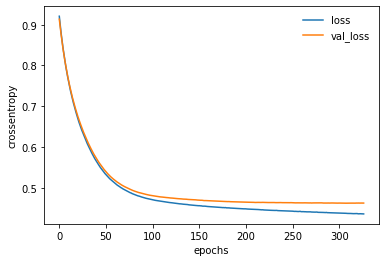

In [45]:
# グラフ表示
plt.plot(log.history['loss'], label='loss')
plt.plot(log.history['val_loss'], label='val_loss')
plt.legend(frameon=False) # 凡例の表示
plt.xlabel("epochs")
plt.ylabel("crossentropy")
plt.show()

In [46]:
Y_pred = model.predict(X_test)

# 二値分類は予測結果の確率が0.5以下なら0,
# それより大きければ1となる計算で求める
Y_pred_probability = (Y_pred > 0.5).astype("int32")
Y_pred_ = Y_pred_probability.reshape(-1)


5/5 [==============================] - 0s 3ms/step


In [47]:
print(classification_report(Y_test, Y_pred_))

              precision    recall  f1-score   support

           0       0.82      0.74      0.78        80
           1       0.75      0.83      0.78        75

    accuracy                           0.78       155
   macro avg       0.78      0.78      0.78       155
weighted avg       0.78      0.78      0.78       155



**精度の考察**

正答率、f値が78％となり、高度な確率で能力値が予測できています。

**モデルのチューニング**

以下の試行を行いモデルをチューニングしました。

・違う説明変数で試す。

・新しい説明変数を作る。

・データのサンプリング手法

・ノード数、隠れ層数を変える

・データの標準化

・ドロップアウト層をつける（精度が下がったため最終の分析には含まず）

・違うオプティマイザで試す

・重み正則化をつける


**能力値の予測**

最後に、例として、サッカー日本代表久保建英選手の2022年時点での能力値を用いて、
久保選手が5年後2027年に、総合能力値80を超え、世界のトッププレーヤーの仲間入りを果たしているかを予測します。

In [48]:
df[df['long_name'].str.contains('久保 建英')]

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
1896,237681,https://sofifa.com/player/237681/takefusa-kubo...,T. Kubo,久保 建英,"RM, CM, CAM",75,88,13500000.0,77000.0,20,2001-06-04,173,67,453.0,RCD Mallorca,Spain Primera Division,1.0,CAM,17.0,Real Madrid CF,NaN,2022.0,163,Japan,NaN,NaN,NaN,Left,4,4,1,High/Medium,Lean (170-185),No,NaN,NaN,"Flair, Technical Dribbler (AI)",81.0,66.0,68.0,82.0,39.0,56.0,61,70,39,73,57,85,68,72,58,81,89,74,86,65,83,66,54,76,52,60,43,29,68,72,61,70,40,43,48,6,7,15,10,10,NaN,68+2,68+2,68+2,75,73,73,73,75,74+2,74+2,74+2,74+2,68+2,68+2,68+2,74+2,60+2,56+2,56+2,56+2,60+2,57+2,47+2,47+2,47+2,57+2,15+2,https://cdn.sofifa.net/players/237/681/22_120.png,https://cdn.sofifa.net/teams/453/60.png,https://cdn.sofifa.net/flags/es.png,NaN,https://cdn.sofifa.net/flags/jp.png


In [52]:
Kubo_data_array = np.array([5,20,0,0,0,0,0,0,0,0,0,0])

#df_revised2に組み込む
#もう一度正規化を実施
#数値を把握

久保選手の数値は標準化されていないのでこのままだと分析できません。df2017_revised2に久保選手の値も組み込んで標準化します。

In [54]:
df2017_revised2_kubo = df2017_revised2.append(
{'distance_to_80':5,
 'age':20,
 'nationality_name_Argentina':0,
 'nationality_name_Belgium':0,
 'nationality_name_Brazil':0,
 'nationality_name_England':0,
 'nationality_name_France':0,
 'nationality_name_Germany':0,
 'nationality_name_Italy':0,
 'nationality_name_Netherlands':0,
 'nationality_name_Portugal':0,
 'nationality_name_Spain':0}, ignore_index=True)

C:\Users\x250\AppData\Local\Temp\ipykernel_14564\2682928278.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2017_revised2_kubo = df2017_revised2.append(


In [68]:
#リストの一番下の列に組み込まれている
df2017_revised2_kubo.tail()

,sofifa_id,short_name,overall,distance_to_80,over80_2022,overall2022,nationality_name,age,nationality_name_Argentina,nationality_name_Belgium,nationality_name_Brazil,nationality_name_England,nationality_name_France,nationality_name_Germany,nationality_name_Italy,nationality_name_Netherlands,nationality_name_Portugal,nationality_name_Spain
7047,234229.0,R. McCrorie,48.0,32,0.0,68.0,Scotland,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7048,233565.0,J. Koroma,47.0,33,0.0,68.0,England,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7049,233841.0,C. Cuesta,47.0,33,0.0,72.0,Colombia,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7050,229393.0,S. Hornby,46.0,34,0.0,61.0,England,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7051,NaN,NaN,NaN,5,NaN,NaN,NaN,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
sc = StandardScaler()
df2017_temp2 = df2017_revised2_kubo[["distance_to_80","age"]]
std_kubo = sc.fit_transform(df2017_temp2)

In [61]:
Kubo_distance_to_80 = std_kubo[-1,0]
Kubo_df_age = std_kubo[-1,1]


In [69]:
#正規化された後の、久保選手の現在能力値と能力値80までの差と、年齢
print(Kubo_distance_to_80)
print(Kubo_df_age)

-1.2370362256577734
-0.9851389252420434


In [66]:
Kubo_data_array = np.array([[Kubo_distance_to_80,Kubo_df_age,0,0,0,0,0,0,0,0,0,0]])


久保選手の選手データを、先ほどの学習したモデルに当てはめます。

In [67]:
Kubo_pred = model.predict(Kubo_data_array)
Kubo_pred

1/1 [==============================] - 0s 32ms/step


array([[0.9023558]], dtype=float32)

**考察**

久保建英選手が5年後に能力値80に到達する可能性
は90.2%でした。

ほぼ間違いなく久保選手は5年後に世界のトッププレーヤーの仲間入りを果たすと言えそうです。